<a href="https://colab.research.google.com/github/desstaw/PrivacyPreservingTechniques/blob/main/K_Anonymity_sepsis_k%3D5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The value assigned to k affects the total number of records strongly.

When:

k = 3 --> 440 records, 150 violations

k = 4 --> 339 records, 119 violations

k = 5 --> 259 records, 92 violations

Here the quasi identifiers are: `['Age', 'Gender', 'HR', 'SBP', 'MAP', 'DBP']`

In [55]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import random


# Load data
url = "https://raw.githubusercontent.com/desstaw/PrivacyPreservingTechniques/main/datasets/sepsis.csv"
df = pd.read_csv(url)

import warnings
warnings.simplefilter('ignore')

### K-anonymity on original heart ds

**Explanation**:

1. Apply generalization to the quasi-identifiers:
This step applies the generalization hierarchy to each quasi-identifier in the dataset using the pandas "cut" function. This function cuts a Series into bins and then labels the bins with the provided categories. In this code, each quasi-identifier is cut into bins based on the corresponding generalization hierarchy defined earlier.

2. Define "k" that represents the minimum number of individuals that must be in a group to avoid suppression.

3. Group the dataset by the quasi-identifiers and suppress any groups with less than k individuals by adding their indices to the "suppressed_indices" list. Then use "groupby" function to group the dataset by the quasi-identifiers, and then a loop is used to check if each group has at least k individuals. If a group has fewer than k individuals, its indices are added to the "suppressed_indices" list.

4. Drops the rows with indices in the "suppressed_indices" list from the dataset to ensure that all data is now k-anonymous.

In [56]:
df = df[['Age', 'Gender', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'Hgb', 'WBC', 'Glucose', 'SepsisLabel']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1001 non-null   int64  
 1   Gender       1001 non-null   float64
 2   HR           1001 non-null   float64
 3   O2Sat        1001 non-null   float64
 4   Temp         1001 non-null   float64
 5   SBP          1001 non-null   float64
 6   MAP          998 non-null    float64
 7   DBP          1001 non-null   float64
 8   Resp         996 non-null    float64
 9   Hgb          915 non-null    float64
 10  WBC          914 non-null    float64
 11  Glucose      951 non-null    float64
 12  SepsisLabel  1001 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 101.8 KB


In [57]:
df.head(10)

,Age,Gender,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Hgb,WBC,Glucose,SepsisLabel
0,50,1.0,72.115385,98.153846,36.607692,105.846154,76.807692,63.461538,20.416667,8.00,14.30,121.250000,0.0
1,51,1.0,77.283333,96.758065,36.920000,145.396552,102.275862,73.741379,15.071429,6.40,3.00,97.500000,0.0
2,71,1.0,100.403846,94.788462,37.086538,130.400000,87.160000,65.880000,19.384615,12.30,22.40,137.266667,0.0
3,51,0.0,76.315789,96.500000,36.161538,153.763158,104.716216,74.236842,19.171053,9.75,7.15,103.944444,0.0
4,73,1.0,51.395349,95.469697,36.122222,133.131212,85.112903,69.474848,17.545455,12.40,7.85,96.000000,0.0
5,61,0.0,65.954545,94.906977,37.157143,113.295455,81.090909,62.477273,14.068182,8.95,6.70,78.750000,0.0
6,66,1.0,80.583333,97.166667,36.541667,101.194444,74.222222,59.527778,15.611111,10.85,19.30,133.000000,0.0
7,43,1.0,112.033333,95.600000,36.166667,117.733333,93.266667,81.766667,15.900000,8.90,5.80,90.000000,0.0
8,75,1.0,90.985714,96.400000,37.484091,128.357143,88.114286,66.385714,19.382353,10.85,11.80,137.722222,0.0
9,85,0.0,81.220930,98.500000,36.327273,106.697674,72.279070,52.755814,15.050000,NaN,NaN,NaN,0.0


In [58]:
df.describe()

,Age,Gender,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Hgb,WBC,Glucose,SepsisLabel
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,998.000000,1001.000000,996.000000,915.000000,914.000000,951.000000,1001.000000
mean,60.881119,0.541459,82.760377,97.109213,36.715467,126.985841,87.243943,66.947442,18.483021,10.692163,10.191952,131.674454,0.018480
std,17.067597,0.498527,15.118607,1.931453,0.529815,18.515599,13.142127,10.777368,2.956994,2.093911,5.008229,36.065396,0.110062
min,17.000000,0.000000,45.714286,76.960526,33.105769,79.350877,49.000000,35.159574,1.900000,6.100000,0.200000,74.000000,0.000000
25%,50.000000,0.000000,72.055556,96.017241,36.400000,113.136364,77.816602,59.228571,16.744231,9.050000,6.900000,107.600000,0.000000
50%,62.000000,1.000000,81.291667,97.280000,36.681818,125.640625,85.630012,66.073529,18.246429,10.550000,9.450000,125.145833,0.000000
75%,72.000000,1.000000,92.500000,98.466667,37.009091,139.288462,95.077830,73.741379,19.890351,12.200000,12.200000,143.750000,0.000000
max,100.000000,1.000000,129.328947,100.000000,38.660000,203.775000,140.000000,115.136364,37.378788,18.400000,61.500000,360.954545,1.000000


In [59]:
df.isnull().sum()
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907 entries, 0 to 1000
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          907 non-null    int64  
 1   Gender       907 non-null    float64
 2   HR           907 non-null    float64
 3   O2Sat        907 non-null    float64
 4   Temp         907 non-null    float64
 5   SBP          907 non-null    float64
 6   MAP          907 non-null    float64
 7   DBP          907 non-null    float64
 8   Resp         907 non-null    float64
 9   Hgb          907 non-null    float64
 10  WBC          907 non-null    float64
 11  Glucose      907 non-null    float64
 12  SepsisLabel  907 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 99.2 KB


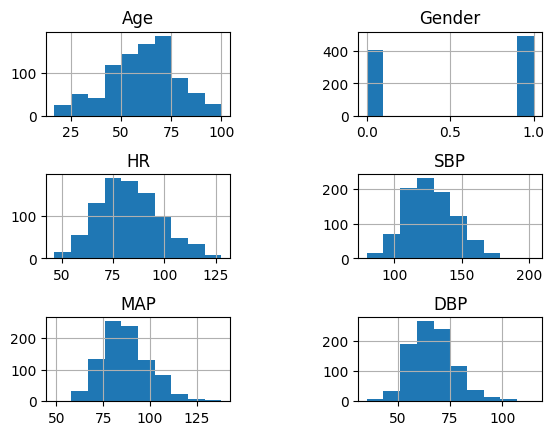

In [60]:
df.hist(column=['Age', 'Gender', 'HR', 'SBP', 'MAP', 'DBP'], bins=10)
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.show()


In [61]:
# Define the sensitive attribute and the quasi-identifiers
sensitive_attribute = 'SepsisLabel'
quasi_identifiers = ['Age', 'Gender','HR', 'SBP', 'MAP', 'DBP' ]


# Categorize the Gender class
df['Gender'] = df['Gender'].astype('category')

# Round HR and Resp to the nearest 5 and convert to int
df['HR'] = (df['HR'] / 5).round() * 5
df['HR'] = df['HR'].astype(int)

df['Resp'] = (df['Resp'] / 5).round() * 5
df['Resp'] = df['Resp'].astype(int)

# Round SBP, MAP and DBP to the nearest 10 and convert to int
df['SBP'] = (df['SBP'] / 10).round() * 10
df['SBP'] = df['SBP'].astype(int)

df['MAP'] = (df['MAP'] / 10).round() * 10
df['MAP'] = df['MAP'].astype(int)

df['DBP'] = (df['DBP'] / 10).round() * 10
df['DBP'] = df['DBP'].astype(int)



# Define the generalization hierarchy for each quasi-identifier
generalization_hierarchy = {
    'Age': pd.cut(df['Age'], bins=[17, 39, 49, 59, 69, 100]),
    'HR': pd.cut(df['HR'], bins=[0, 60, 70, 80, 90, 100, 130]),
    'SBP': pd.cut(df['SBP'], bins=[0, 120, 130, 140, 150, 160, 210]),
    'MAP': pd.cut(df['MAP'], bins=[0, 70, 90, 100, 160]),
    'DBP': pd.cut(df['DBP'], bins=[0, 50, 70, 90, 120]),
    #'Resp': pd.cut(df['Resp'], bins=[1, 15, 20, 25, 50]),
}
for col, hierarchy in generalization_hierarchy.items():
    df[col] = pd.cut(df[col], bins=hierarchy.cat.categories, labels=hierarchy.cat.categories[:-1])


# Print the distribution of values in their intervals
print(df["Age"].value_counts().sort_index())
print(df["HR"].value_counts().sort_index())
print(df["SBP"].value_counts().sort_index())
print(df["MAP"].value_counts().sort_index())
print(df["DBP"].value_counts().sort_index())
print(df["Resp"].value_counts().sort_index())


# Define the privacy parameter
k = 5

# Group the dataset by the quasi-identifiers and suppress the groups with less than k rows
grouped = df.groupby(quasi_identifiers)
suppressed_indices = []
for group_name, group in grouped:
    if len(group) < k:
        suppressed_indices.extend(group.index)
df = df.drop(suppressed_indices)
#df.info()
# Restore the original index
df_index = df.index
df = df.reset_index(drop=True)

counter = 0
for index in suppressed_indices:
    counter = counter + 1
    #print(df.loc[index])
    #print("------------")
print('sum of supressed records:', counter)

(17, 39]     104
(39, 49]     118
(49, 59]     178
(59, 69]     221
(69, 100]    285
Name: Age, dtype: int64
(0, 60]        68
(60, 70]      167
(70, 80]      246
(80, 90]      200
(90, 100]     128
(100, 130]     98
Name: HR, dtype: int64
(0, 120]      440
(120, 130]    165
(130, 140]    149
(140, 150]     84
(150, 160]     43
(160, 210]     26
Name: SBP, dtype: int64
(0, 70]       148
(70, 90]      532
(90, 100]     144
(100, 160]     83
Name: MAP, dtype: int64
(0, 50]      109
(50, 70]     618
(70, 90]     169
(90, 120]     11
Name: DBP, dtype: int64
0       1
5       1
10     16
15    308
20    511
25     63
30      5
35      2
Name: Resp, dtype: int64
sum of supressed records: 648


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Age          258 non-null    category
 1   Gender       259 non-null    category
 2   HR           259 non-null    category
 3   O2Sat        259 non-null    float64 
 4   Temp         259 non-null    float64 
 5   SBP          259 non-null    category
 6   MAP          259 non-null    category
 7   DBP          259 non-null    category
 8   Resp         259 non-null    int64   
 9   Hgb          259 non-null    float64 
 10  WBC          259 non-null    float64 
 11  Glucose      259 non-null    float64 
 12  SepsisLabel  259 non-null    float64 
dtypes: category(6), float64(6), int64(1)
memory usage: 17.2 KB


In [63]:
df.head(20)

,Age,Gender,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Hgb,WBC,Glucose,SepsisLabel
0,"(49, 59]",1.0,"(60, 70]",98.153846,36.607692,"(0, 120]","(70, 90]","(50, 70]",20,8.000000,14.300000,121.250000,0.000000
1,"(69, 100]",1.0,"(0, 60]",95.469697,36.122222,"(120, 130]","(70, 90]","(50, 70]",20,12.400000,7.850000,96.000000,0.000000
2,"(69, 100]",1.0,"(80, 90]",96.400000,37.484091,"(120, 130]","(70, 90]","(50, 70]",20,10.850000,11.800000,137.722222,0.000000
3,"(49, 59]",1.0,"(80, 90]",95.350000,36.120000,"(0, 120]","(70, 90]","(50, 70]",20,18.400000,5.200000,225.166667,0.000000
4,"(69, 100]",1.0,"(70, 80]",96.730769,36.872727,"(120, 130]","(70, 90]","(50, 70]",15,9.800000,9.000000,119.027500,0.000000
5,"(69, 100]",1.0,"(60, 70]",99.384211,36.686957,"(130, 140]","(70, 90]","(50, 70]",20,10.140000,10.060000,126.500000,0.098039
6,"(59, 69]",1.0,"(60, 70]",95.843750,36.825000,"(0, 120]","(70, 90]","(50, 70]",15,7.900000,7.700000,112.000000,0.000000
7,"(49, 59]",1.0,"(70, 80]",97.529412,36.433333,"(0, 120]","(70, 90]","(50, 70]",20,12.750000,10.850000,74.000000,0.000000
8,"(69, 100]",1.0,"(0, 60]",92.109756,36.555556,"(120, 130]","(70, 90]","(50, 70]",20,11.750000,10.300000,123.000000,0.000000
9,"(69, 100]",0.0,"(70, 80]",97.545455,37.000000,"(0, 120]","(0, 70]","(0, 50]",20,8.200000,14.800000,227.066667,0.000000


Test the k-anonimity:

**Explanation**

`for qi_vals, group in df.groupby(qi_cols):`group the records in the df based on the values of the quasi-identifiers. For each group of records, the variable qi_vals contains the values of the quasi-identifiers for the group, and the variable group contains the records in the group.

`counts = Counter(df[qi_cols].apply(tuple, axis=1))`: creates a Counter object that counts the number of occurrences of each combination of quasi-identifiers in the dataframe df. The apply() function is used to apply the tuple() function to each row of the dataframe, which converts the values of the quasi-identifiers in each row to a tuple.

`num_violations = len([count for count in counts.values() if count < k_anonymity])`: This line counts the number of records in the dataframe df that do not satisfy k-anonymity. It does this by iterating over the values of the Counter object counts and counting the number of values that are less than the value of k.

In [64]:
from collections import Counter
# Convert interval column to string type
df['Age'] = df['Age'].astype(str)
df['Gender'] = df['Gender'].astype(str)
df['HR'] = df['HR'].astype(str)
df['SBP'] = df['SBP'].astype(str)
df['MAP'] = df['MAP'].astype(str)
df['DBP'] = df['DBP'].astype(str)



# Define the quasi-identifiers (hard-coded)
qi_cols = ['Age', 'Gender','HR', 'Resp', 'SBP', 'MAP', 'DBP' ]

# Define the value of k for k-anonymity
k_anonymity = 5

# Calculate the frequency count of unique combinations of quasi-identifiers
qi_counts = df[qi_cols].apply(tuple, axis=1).value_counts()

# Find the number of records that do not satisfy k-anonymity
num_violations = (qi_counts < k_anonymity).sum()

print("Number of records that do not satisfy k-anonymity:", num_violations)

Number of records that do not satisfy k-anonymity: 92


Test l-diversity

In [65]:
from collections import Counter

sensitive_attribute = 'SepsisLabel'

l_diversity = 2

# Initialize counter
count = 0

# Define the quasi-identifiers
#qi_cols = [col for col in df.columns if col != sensitive_attribute]
qi_cols = ['Age', 'Gender']

# Check l-diversity for each group of records
for qi_vals, group in df.groupby(qi_cols):
    if len(group[sensitive_attribute].unique()) < l_diversity:
        count += len(group)
        #print("l-diversity is not satisfied for the group:", qi_vals)
# Print the total number of records that do not satisfy l-diversity
print(f"Total number of records that do not satisfy l-diversity: {count}")

Total number of records that do not satisfy l-diversity: 32


In [66]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/Sepsis/v2_sepsis.csv', index=False)